<a href="https://colab.research.google.com/github/SaMoAAlamdari/YouTube_Data_Collection_And_Analysis/blob/main/YouTubeDataCollectionAndAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import Libraries & Load Environment Variables

Importing Essential Libraries:
My code begins by importing core libraries:
- Pandas: For data manipulation and DataFrame operations.
- build from googleapiclient.discovery: To interact with the YouTube API.
- OS module: To retrieve environment variables.

In [5]:
!pip install isodate

In [6]:
import pandas as pd
from googleapiclient.discovery import build # type: ignore
import os
import isodate
import matplotlib.pyplot as plt
import seaborn as sns
import math


### 2. Fetch Trending Videos via YouTube API

- Defining get_trending_videos:
This function establishes a connection with the YouTube API and fetches trending videos.
    - Building the YouTube Service:
    
        The build() function instantiates the YouTube API service with the provided API key.
    
    - Initial API Request:

        The initial request is made with parameters specifying:
        - part: Requests snippets, content details, and statistics.
        - chart: Set to 'mostPopular' to retrieve trending videos.
        - regionCode: Restricts the search to the US.
        - maxResults: Limited to 50 (the maximum per API call).

    - Pagination Loop:
    
        Since the API returns a maximum of 50 items per call, the code uses a while loop with youtube.videos().list_next() to paginate through results until it reaches up to max_results (default 200).

    - Extracting Video Details:

        For every item in the API response, the code extracts key details such as:
        - Video ID, title, and description.
        - Publication date and channel information.
        - Category, tags, duration, and various engagement metrics (views, likes, dislikes, etc.).

    - Returning Results:
        Finally, it returns a list of video details (capped at max_results).
    
    - Main Execution Block:
        The main() function calls get_trending_videos using the API key, saves the resulting data to a file (trending_videos.csv), and then prints a confirmation message.


In [7]:
def get_trending_videos(api_key, max_results=200):
    # build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # initialize the list to hold video details
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        chart='mostPopular',
        regionCode='US',
        maxResults=50
    )

    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)

        # get the next page token
        request = youtube.videos().list_next(request, response)

    return videos[:max_results]

### 3. Save Data to CSV


In [8]:
API_KEY = 'Your_API_Key'
def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f'Trending videos saved to {filename}')

if __name__ == '__main__':
    main()

Trending videos saved to trending_videos.csv


### 4. Data Cleaning & Transformation

In [9]:
trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())

      video_id                                              title  \
0  jzkhx_1UlUA  Canelo Álvarez vs William Scull | Fight Highli...   
1  NqrDJmmh1AA       Kentucky Derby 2025 (FULL RACE) | NBC Sports   
2  F7dJY0jkpyU  YoungBoy Never Broke Again - Where I Been / Sh...   
3  hlTGjc7Gn04                Dream VS Daquavis $100,000 PvP Duel   
4  NCwLdschtSk  Reinier de Ridder knocks out Bo Nickal in UFC ...   

                                         description          published_at  \
0  Subscribe to our YouTube channel 👉 http://bit....  2025-05-04T06:08:32Z   
1  Watch the full Run for the Roses at the 151st ...  2025-05-03T23:18:52Z   
2  YoungBoy Never Broke Again –  \nNew Music: htt...  2025-05-03T00:42:17Z   
3  Dream VS Daquavis $100,000 PvP Duel. This is t...  2025-05-03T17:00:06Z   
4  Reinier de Ridder uses a well-balanced attack ...  2025-05-04T04:37:57Z   

                 channel_id               channel_title  category_id  \
0  UCurvRE5fGcdUgCYWgh-BDsg                 

In [10]:
# check for missing values
missing_values = trending_videos.isnull().sum()

# display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       1
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

- Data Cleaning Steps:
    - Missing Descriptions: Missing descriptions are filled with "No description".

    - Datetime Conversion: The published_at column is converted to a datetime format.

    - Tags Conversion: Since tags are stored as string representations of lists, a lambda using eval() converts them into actual Python lists.
    
    - Descriptive Statistics: Basic descriptive statistics for engagement metrics (view, like, dislike, comment counts) are generated using .describe().



In [11]:
# fill missing descriptions with "No description"
trending_videos['description'].fillna('No description')

# convert `published_at` to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

### 5. Exploratory Data Analysis (EDA)

In [12]:
# descriptive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,2.000000e+02,2.000000e+02,200.0,200.000000
mean,2.319432e+06,7.236032e+04,0.0,5811.995000
std,7.331682e+06,1.917784e+05,0.0,9719.090628
min,4.936500e+04,0.000000e+00,0.0,0.000000
25%,4.330818e+05,1.251775e+04,0.0,1278.250000
50%,9.164205e+05,2.872000e+04,0.0,2517.000000
75%,1.856201e+06,6.571725e+04,0.0,5324.750000
max,9.496864e+07,2.344138e+06,0.0,61781.000000


### 6. Visualization Code

#### Distributions: View count, likes, comments (histograms).

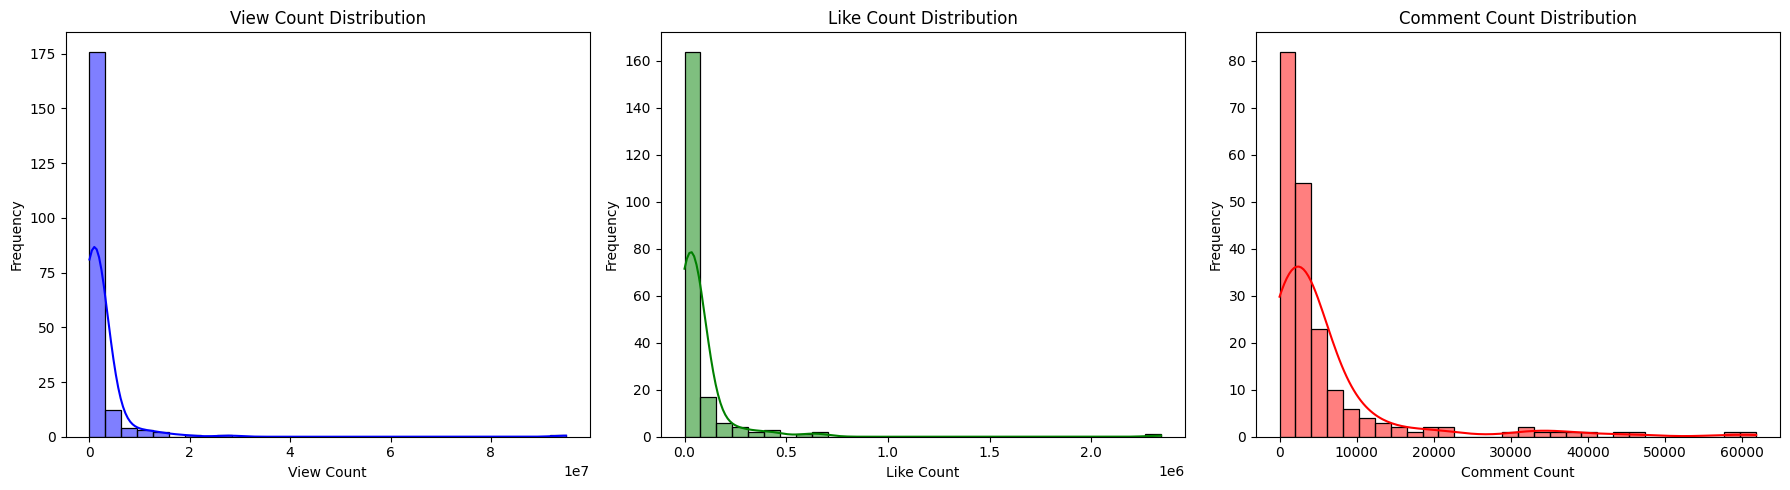

In [13]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Correlation Heatmap: Shows relationships between engagement metrics.

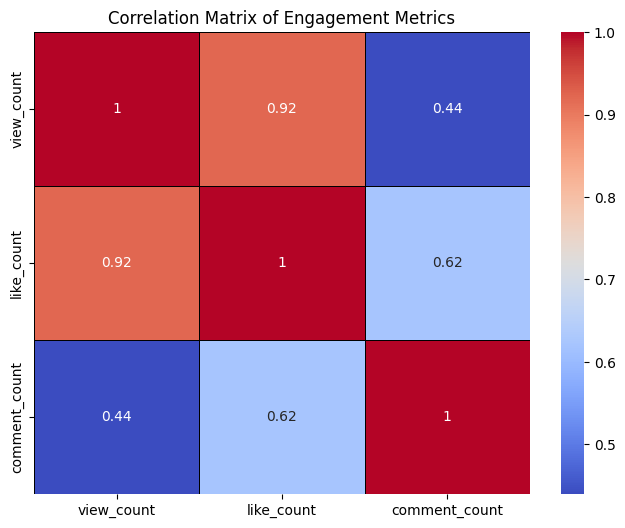

In [14]:
# correlation matrix
correlation_matrix = trending_videos[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

#### Category Analysis: Bar charts for video counts and engagement by category.

In [15]:
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


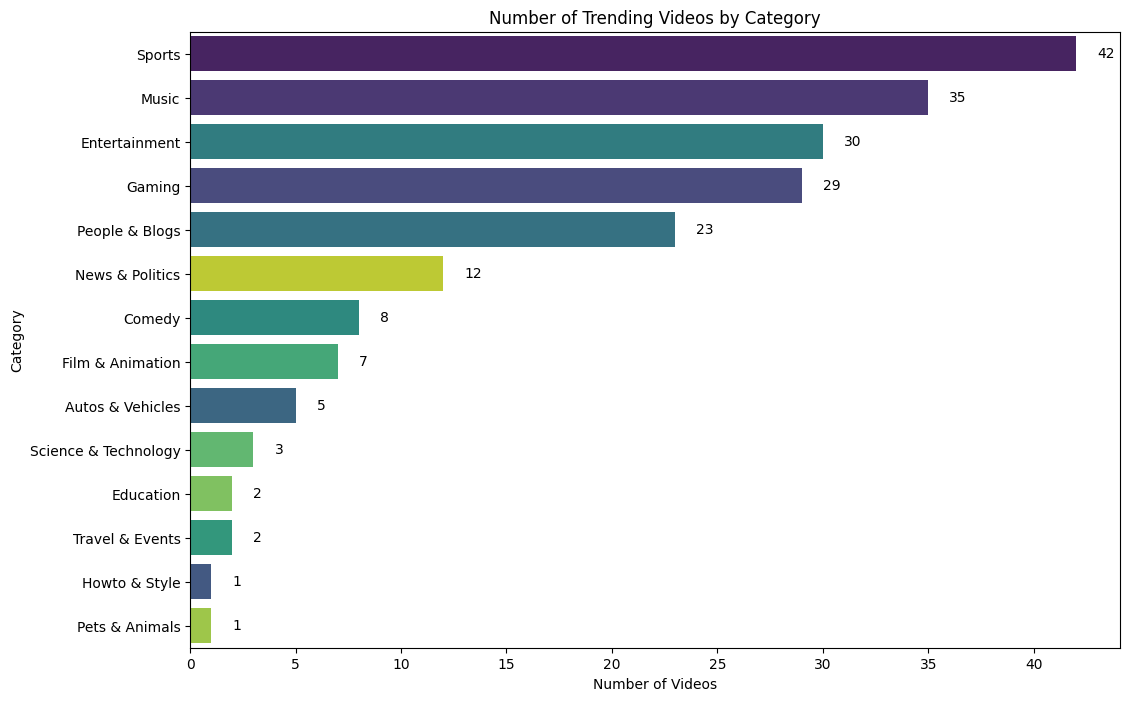

In [16]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

# Bar chart for category counts
plt.figure(figsize=(12, 8))
ax=sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, hue=trending_videos['category_name'], palette='viridis', legend=False )
# Add the counts on each bar
for bar in ax.patches:
    # Get bar dimensions
    count = int(bar.get_width())  # The bar width is the count
    y_pos = bar.get_y() + bar.get_height() / 2  # Center the text in the bar
    ax.text(count + 1, y_pos, str(count), va='center', fontsize=10)  # Slight offset to the right

plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

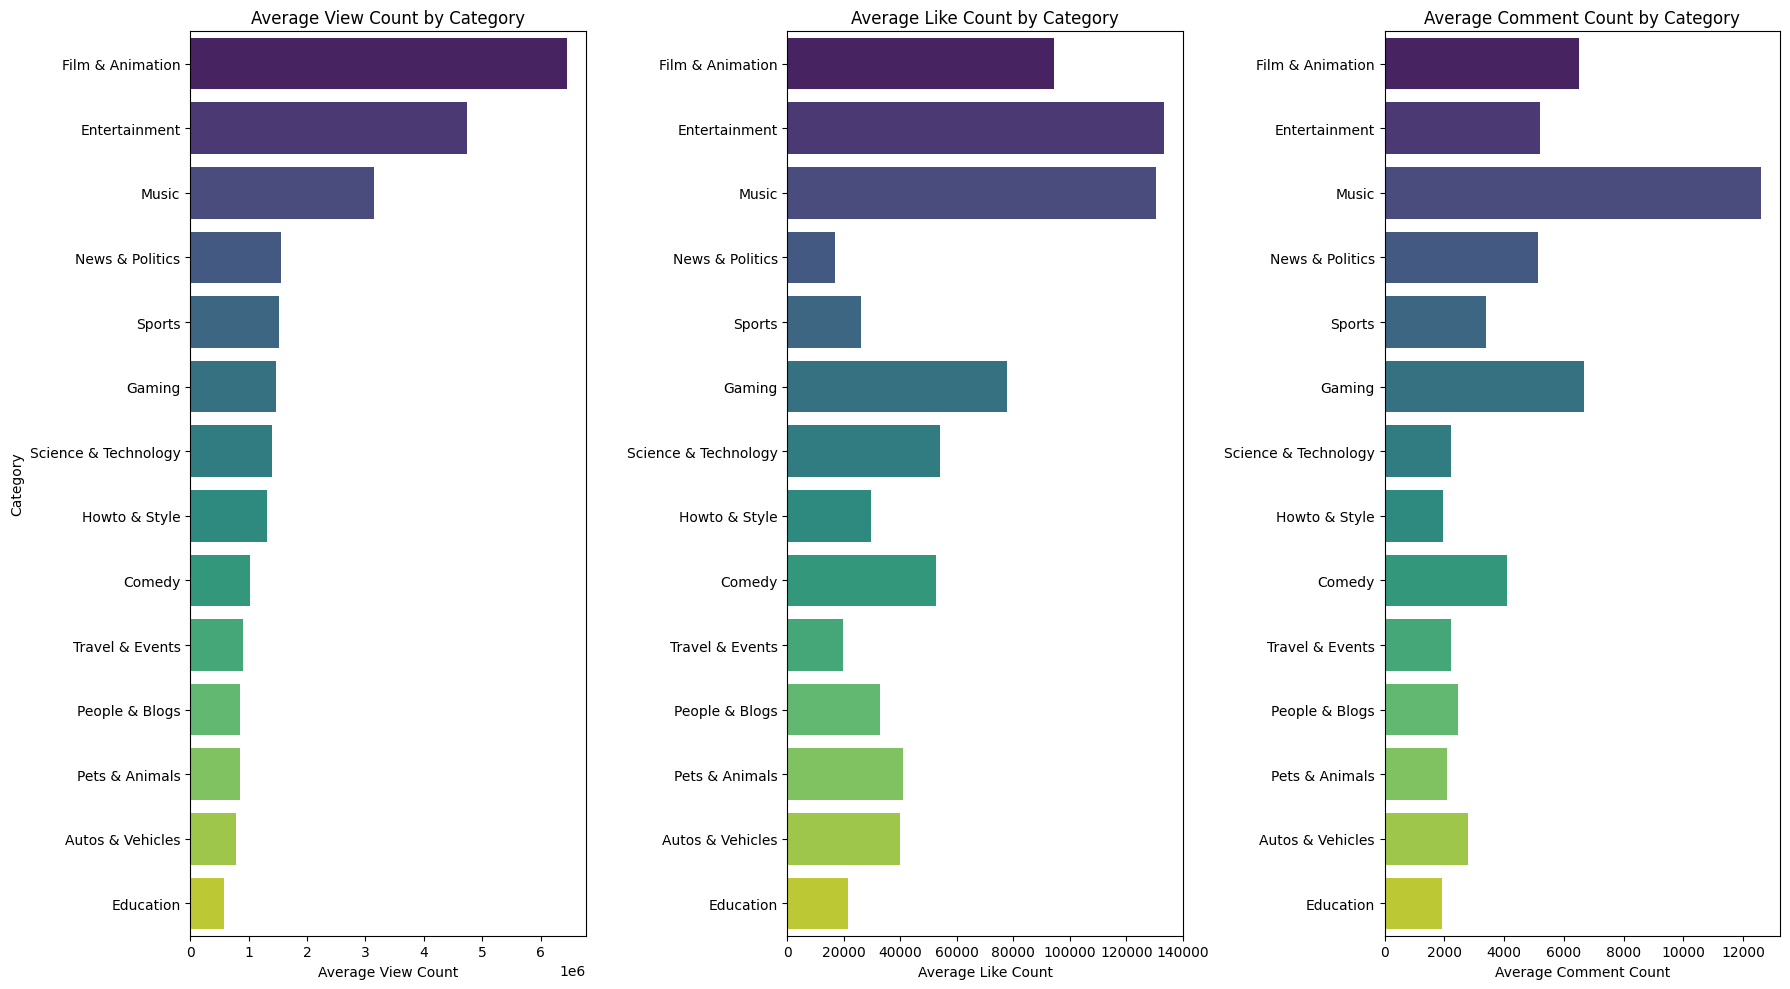

In [17]:
# average engagement metrics by category
category_engagement = trending_videos.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis', hue=category_engagement.index, legend=False)
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

# like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis', hue=category_engagement.index, legend=False)
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis', hue=category_engagement.index, legend=False)
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

#### Video Length Impact: Scatter plots of duration vs. views and engagement by duration bins.

In [18]:
# convert ISO 8601 duration to seconds
trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

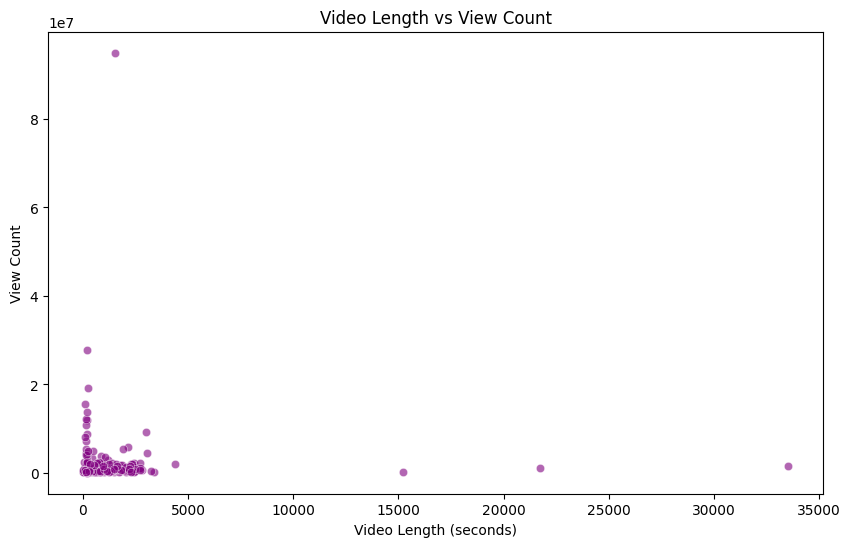

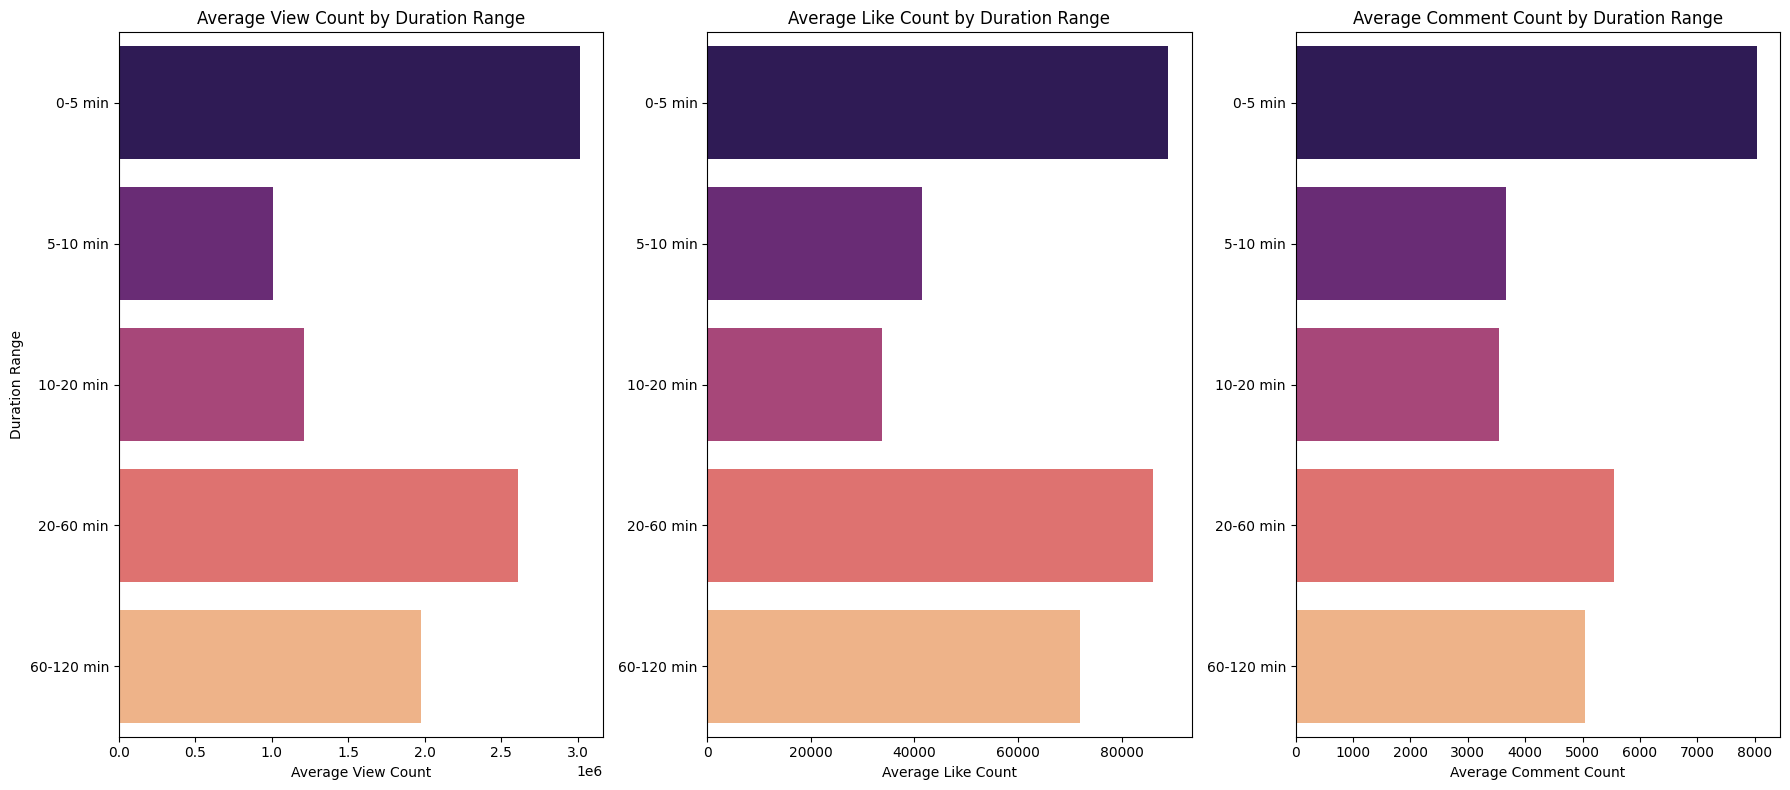

In [19]:
# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('duration_range', observed=False)[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma', hue=length_engagement.index, legend=False)
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma', hue=length_engagement.index, legend=False)
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma', hue=length_engagement.index, legend=False)
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

#### Tag Analysis: Tags vs. views.

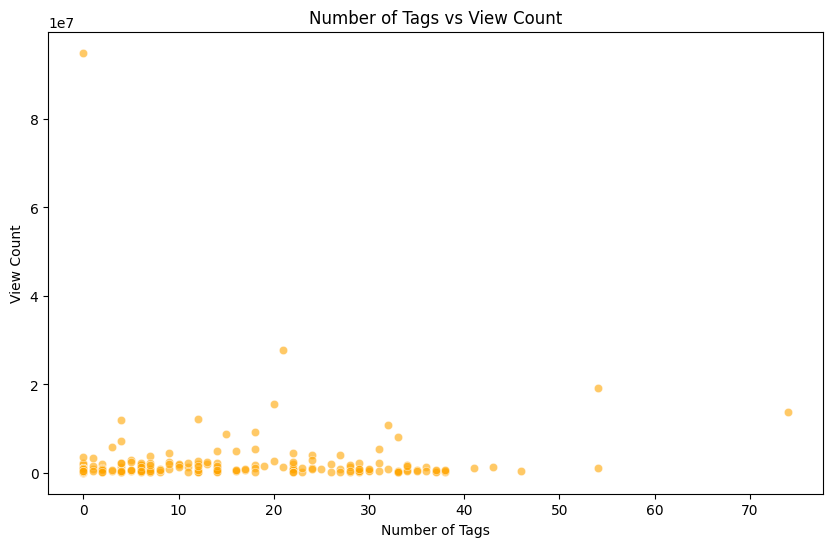

In [20]:
# calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

# scatter plot for number of tags vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

#### Publish Time: Hourly distribution of video uploads.

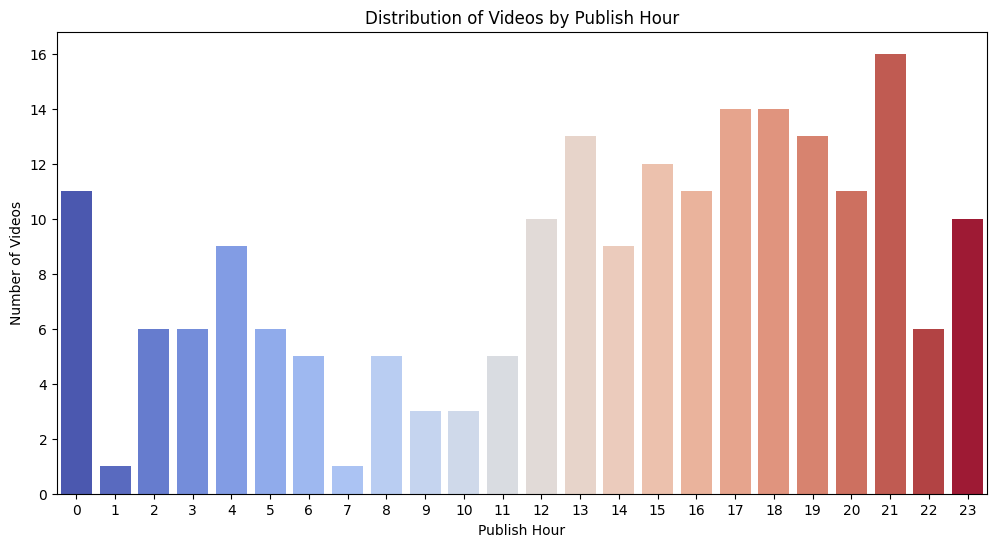

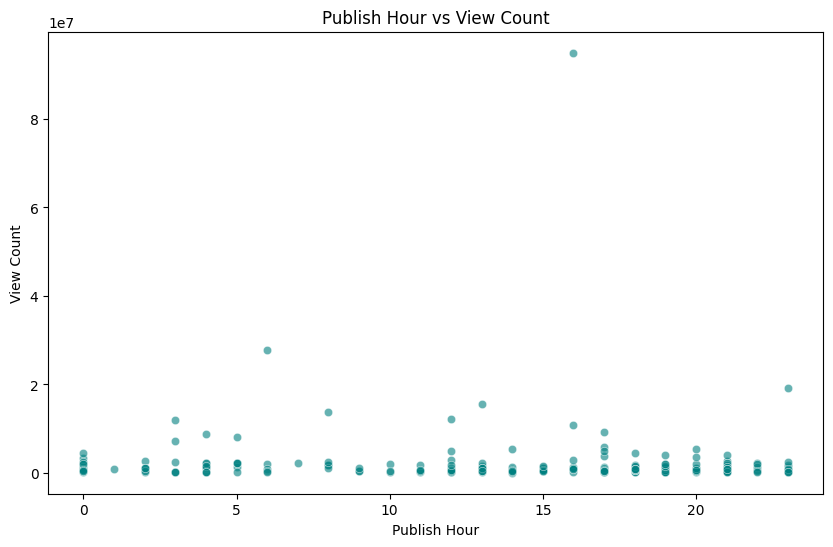

In [21]:
# extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm', hue='publish_hour', legend=False)
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

### 7. Implementing on specific channel

#### 1. Retrieving a Channel's Information

In [22]:
mrbeast_id = 'UCX6OQ3DkcsbYNE6H8uQQuVA'
channel_id = mrbeast_id  # Replace with the desired channel ID

In [23]:
# Build the YouTube API service
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_channel_info(channel_id):
    # Fetch channel details
    request = youtube.channels().list(
        part='snippet,statistics,contentDetails,brandingSettings,topicDetails',
        id=channel_id
    )
    response = request.execute()
    return response

channel_info = get_channel_info(channel_id)


In [24]:
# Flatten the 'items' list and other nested fields
data = channel_info
# Flatten the 'items' list
items_df = pd.json_normalize(data['items'])

# If you also want to flatten other fields (like 'pageInfo'), include them
page_info_df = pd.json_normalize(data['pageInfo'])


# Merge horizontally
channel_info_df = pd.concat([items_df.reset_index(drop=True), page_info_df.reset_index(drop=True)], axis=1)

# Save to CSV
channel_info_df.to_csv('channel_info_df.csv', index=False)


#### 2. Fetching All Videos from a Channel

In [25]:
def get_uploaded_videos(playlist_id):
    # Fetch the videos in the uploads playlist
    videos = []
    request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        playlistId=playlist_id,
        maxResults=50
    )
    while request:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['contentDetails']['videoId'],
                'title': item['snippet']['title'],
                'published_at': item['contentDetails']['videoPublishedAt']
            }
            videos.append(video_details)
        request = youtube.playlistItems().list_next(request, response)
    return videos

# Extract the "uploads" playlist ID from the channel info
uploads_playlist_id = channel_info['items'][0]['contentDetails']['relatedPlaylists']['uploads']
uploaded_videos = get_uploaded_videos(uploads_playlist_id)


In [26]:
uploaded_videos_df = pd.DataFrame(uploaded_videos)
# check for missing values
missing_values = uploaded_videos_df.isnull().sum()

# display data types
data_types = uploaded_videos_df.dtypes

missing_values, data_types

(video_id        0
 title           0
 published_at    0
 dtype: int64,
 video_id        object
 title           object
 published_at    object
 dtype: object)

In [27]:
uploaded_videos_df['published_at'] = pd.to_datetime(uploaded_videos_df['published_at'])

#### 3. Analyzing Channel Data


Once we’ve retrieved the uploaded videos and channel information, we can analyze it in several ways. Here are a few ideas:

##### A. Engagement Metrics for Videos


In [28]:
def get_video_stats(video_ids):
    # Join all video IDs into a single comma-separated string
    stats = []
    # Divide video IDs into batches of 50
    batch_size = 50
    num_batches = math.ceil(len(video_ids) / batch_size)

    for i in range(num_batches):
        # Get the current batch of up to 50 video IDs
        batch = video_ids[i * batch_size : (i + 1) * batch_size]

        request = youtube.videos().list(
            part='snippet,statistics,contentDetails,status,topicDetails',

            id=','.join(batch)  # Batch of up to 50 IDs
        )
        try:
             response = request.execute()
        except Exception as e:
             print(f"An error occurred: {e}")
             continue


        for item in response.get('items', []):
            video_stats = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet'].get('description', ''),
                'tags': item['snippet'].get('tags', []),
                'category_id': item['snippet'].get('categoryId', ''),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0),
                'duration': item['contentDetails'].get('duration', ''),
                'definition': item['contentDetails'].get('definition', ''),
                'privacy_status': item['status'].get('privacyStatus', ''),
                'topic_categories': item.get('topicDetails', {}).get('topicCategories', [])
            }
            stats.append(video_stats)
    return stats

# Assuming `uploaded_videos` is a list of all uploaded videos
video_ids = [video['video_id'] for video in uploaded_videos]  # Get all video IDs
video_stats = get_video_stats(video_ids)  # Fetch stats for all videos

print("Video Stats:", video_stats)

Video Stats: [{'video_id': '3dxksf0CzS8', 'title': 'World’s Fastest Robbers', 'description': 'That robber kinda looks like @DanielLaBelle', 'tags': [], 'category_id': '24', 'view_count': '107675770', 'like_count': '2959029', 'comment_count': '7630', 'duration': 'PT32S', 'definition': 'hd', 'privacy_status': 'public', 'topic_categories': ['https://en.wikipedia.org/wiki/Entertainment', 'https://en.wikipedia.org/wiki/Humour']}, {'video_id': 'x7yv72s8h0o', 'title': 'Would You Go On Vacation With A Stranger?', 'description': '', 'tags': [], 'category_id': '24', 'view_count': '93901442', 'like_count': '3837650', 'comment_count': '13838', 'duration': 'PT1M3S', 'definition': 'hd', 'privacy_status': 'public', 'topic_categories': ['https://en.wikipedia.org/wiki/Lifestyle_(sociology)', 'https://en.wikipedia.org/wiki/Tourism']}, {'video_id': 'uyiG6uw-6pA', 'title': 'Would You Risk Drowning for $500,000?', 'description': 'These were crazy dangerous so everything was performed under professional sup

In [29]:
video_stats_df = pd.DataFrame(video_stats)
# Convert columns to numeric types
video_stats_df['view_count'] = pd.to_numeric(video_stats_df['view_count'], errors='coerce')
video_stats_df['like_count'] = pd.to_numeric(video_stats_df['like_count'], errors='coerce')
video_stats_df['comment_count'] = pd.to_numeric(video_stats_df['comment_count'], errors='coerce')
video_stats_df['category_id'] = pd.to_numeric(video_stats_df['category_id'], errors='coerce')
video_stats_df['category_name'] = video_stats_df['category_id'].map(category_mapping)
# convert ISO 8601 duration to seconds
video_stats_df['duration_seconds'] = video_stats_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())
video_stats_df['duration_range'] = pd.cut(video_stats_df['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])
# calculate the number of tags for each video
video_stats_df['tag_count'] = video_stats_df['tags'].apply(len)
# extract hour of publication
video_stats_df['publish_hour'] = uploaded_videos_df['published_at'].dt.hour
video_stats_df['published_at'] = uploaded_videos_df['published_at']
#Extract the Day of the Week
video_stats_df['day_of_week'] = video_stats_df['published_at'].dt.day_name()
#Save ti csv
video_stats_df.to_csv('video_stats_df.csv', index=False)


In [30]:
video_stats_df.describe()[['view_count','like_count','comment_count','duration_seconds']]

,view_count,like_count,comment_count,duration_seconds
count,8.670000e+02,8.670000e+02,867.000000,867.000000
mean,9.432077e+07,2.778411e+06,37951.994233,1096.320646
std,1.650131e+08,5.661119e+06,68761.214399,6653.366257
min,5.649800e+04,0.000000e+00,0.000000,11.000000
25%,1.155365e+05,3.249500e+03,451.000000,155.000000
50%,2.382772e+06,9.654400e+04,5107.000000,256.000000
75%,1.495750e+08,3.432846e+06,54156.500000,755.500000
max,1.543317e+09,5.622710e+07,799611.000000,86402.000000


##### B. Publishing Patterns


- Use the published_at timestamps of videos to analyze when the channel uploads content (e.g., by day of the week or time of day).
- This can be helpful in understanding trends in upload frequency.

######  Bar Chart for Day of the Week Distribution

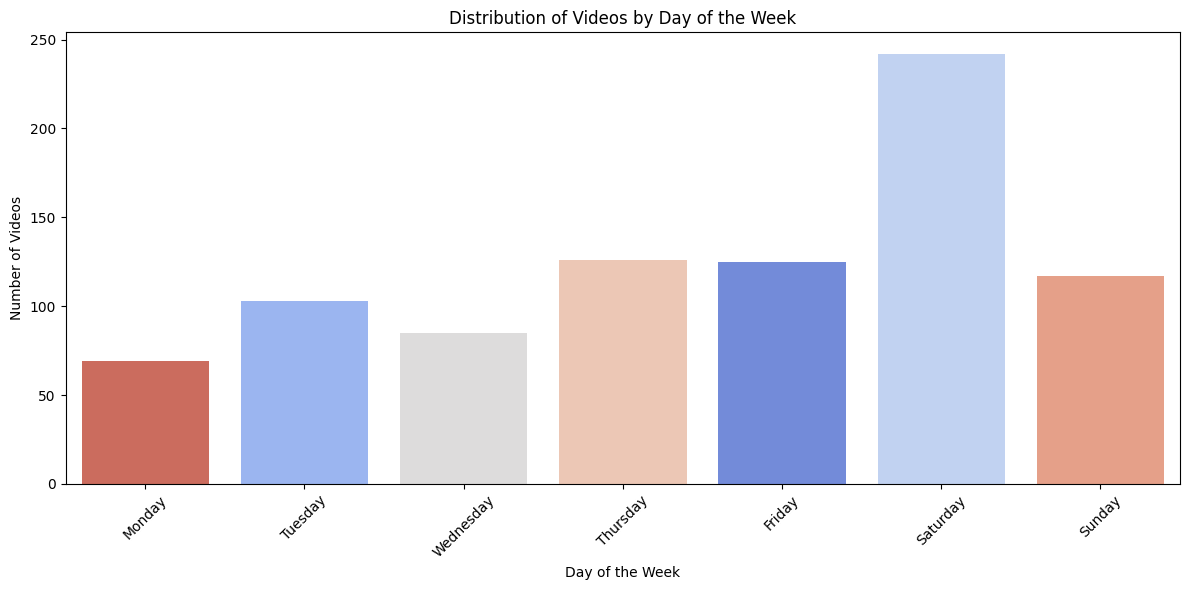

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='day_of_week',
    data=video_stats_df,
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # Order days
    palette='coolwarm',
    hue='day_of_week',
    legend=False
)
plt.title('Distribution of Videos by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

###### Scatter Plot for Day of the Week vs View Count

In [32]:
# Define the correct order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'day_of_week' to a categorical type with the specified order
video_stats_df['categ_day_of_week'] = pd.Categorical(
    video_stats_df['day_of_week'], categories=day_order, ordered=True
)

# Sort the DataFrame by the new categorical order (optional, if you'd like sorted data)
video_stats_df.sort_values('categ_day_of_week', inplace=True)

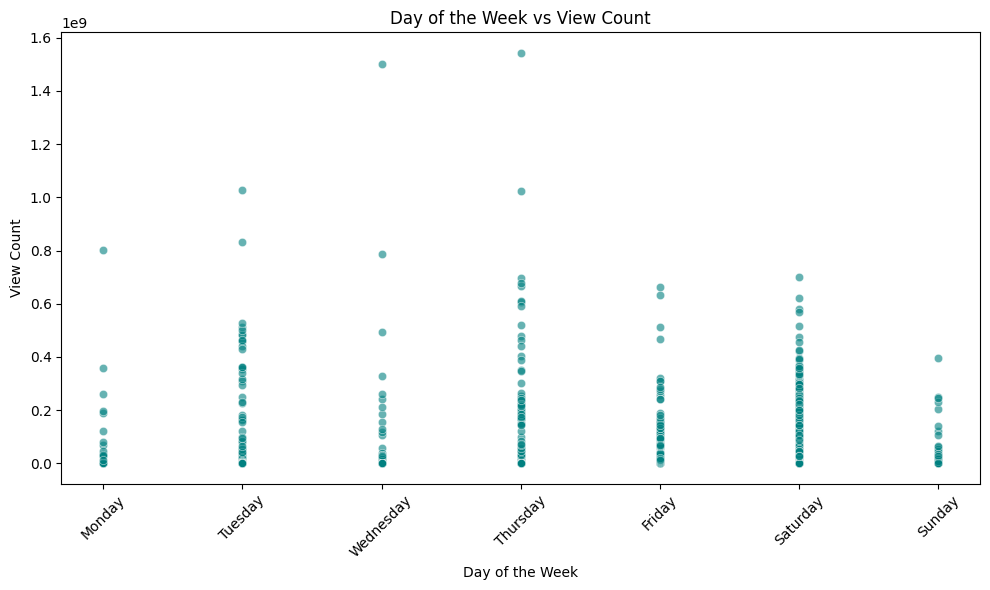

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='categ_day_of_week',
    y='view_count',
    data=video_stats_df,
    alpha=0.6,
    color='teal'
)
plt.title('Day of the Week vs View Count')
plt.xlabel('Day of the Week')
plt.ylabel('View Count')
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.tight_layout()
plt.show()

###### Handling Time Zones:

If the timestamps are in UTC and you'd like to convert them to a local timezone (e.g., Qatar timezone), you can use pytz:

In [34]:
import pytz

# List all available timezones
print(pytz.all_timezones)
print(len(pytz.all_timezones))


# List commonly used timezones (shorter list)
print(pytz.common_timezones)

['Africa/Abidjan', 'Africa/Accra', 'Africa/Addis_Ababa', 'Africa/Algiers', 'Africa/Asmara', 'Africa/Asmera', 'Africa/Bamako', 'Africa/Bangui', 'Africa/Banjul', 'Africa/Bissau', 'Africa/Blantyre', 'Africa/Brazzaville', 'Africa/Bujumbura', 'Africa/Cairo', 'Africa/Casablanca', 'Africa/Ceuta', 'Africa/Conakry', 'Africa/Dakar', 'Africa/Dar_es_Salaam', 'Africa/Djibouti', 'Africa/Douala', 'Africa/El_Aaiun', 'Africa/Freetown', 'Africa/Gaborone', 'Africa/Harare', 'Africa/Johannesburg', 'Africa/Juba', 'Africa/Kampala', 'Africa/Khartoum', 'Africa/Kigali', 'Africa/Kinshasa', 'Africa/Lagos', 'Africa/Libreville', 'Africa/Lome', 'Africa/Luanda', 'Africa/Lubumbashi', 'Africa/Lusaka', 'Africa/Malabo', 'Africa/Maputo', 'Africa/Maseru', 'Africa/Mbabane', 'Africa/Mogadishu', 'Africa/Monrovia', 'Africa/Nairobi', 'Africa/Ndjamena', 'Africa/Niamey', 'Africa/Nouakchott', 'Africa/Ouagadougou', 'Africa/Porto-Novo', 'Africa/Sao_Tome', 'Africa/Timbuktu', 'Africa/Tripoli', 'Africa/Tunis', 'Africa/Windhoek', 'Ameri

In [35]:
keyword = "qatar"
filtered_timezones = [tz for tz in pytz.all_timezones if keyword.lower() in tz.lower()]

print(filtered_timezones)

['Asia/Qatar']


In [36]:
video_stats_df['published_at_ctmz'] = video_stats_df['published_at'].dt.tz_convert(filtered_timezones[0])

In [37]:
video_stats_df['published_at_ctmz']

,published_at_ctmz
866,2012-02-21 01:42:32+03:00
426,2016-10-11 00:05:39+03:00
723,2014-08-18 03:01:52+03:00
419,2016-11-28 03:01:52+03:00
417,2016-12-05 05:21:43+03:00
...,...
759,2014-03-31 02:40:18+03:00
760,2014-03-30 04:52:06+03:00
425,2016-10-16 23:30:00+03:00
305,2018-11-26 00:07:01+03:00


##### C. Topic Analysis


- Extract video titles and descriptions.
- Perform text analysis (e.g., using NLP libraries like spaCy or NLTK) to understand the channel's focus or most common topics.

###### Preprocess the Text Data

Prepare the titles and descriptions for analysis by cleaning and tokenizing:

In [38]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning to the 'title' and 'description' columns
video_stats_df['clean_title'] = video_stats_df['title'].apply(clean_text)
video_stats_df['clean_description'] = video_stats_df['description'].apply(clean_text)

###### Perform Text Analysis with NLP Libraries

Extract keywords, identify topic frequency, and generate word clouds:

<Axes: title={'center': 'Most Common Words in Descriptions'}, xlabel='Samples', ylabel='Counts'>

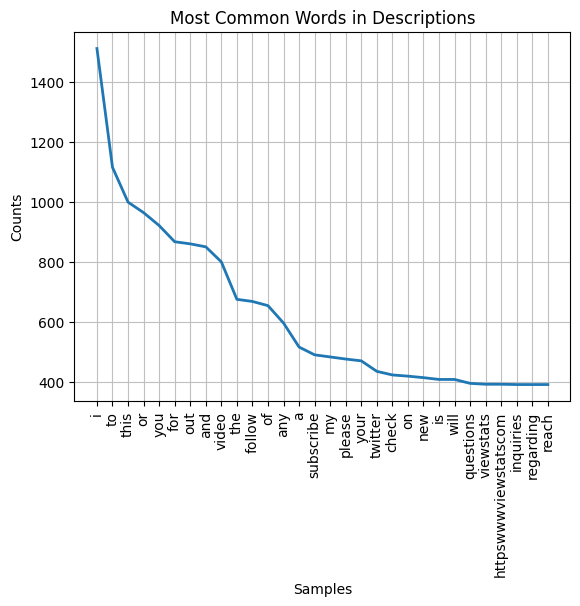

In [39]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Tokenize and calculate frequency distribution
all_words = ' '.join(video_stats_df['clean_description']).split()
fdist = FreqDist(all_words)

# Plot the most common words
fdist.plot(30, title='Most Common Words in Descriptions')

###### Visualize Insights

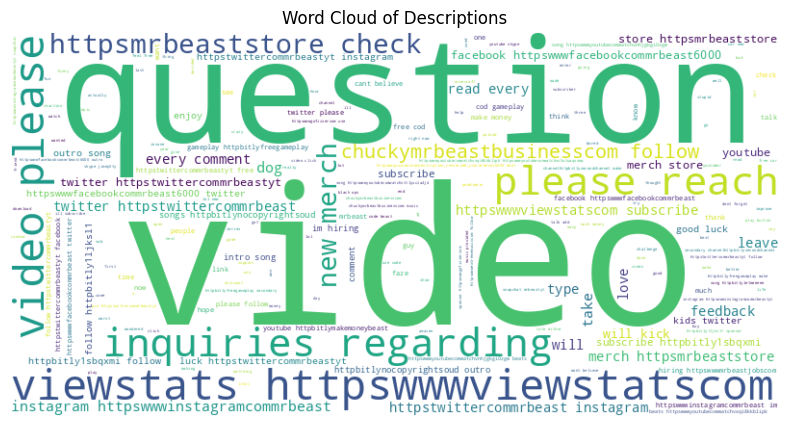

In [40]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(video_stats_df['clean_description']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Descriptions")
plt.show()

#### 4. Visualizing the Data

###### Distributions: View count, likes, comments (histograms).

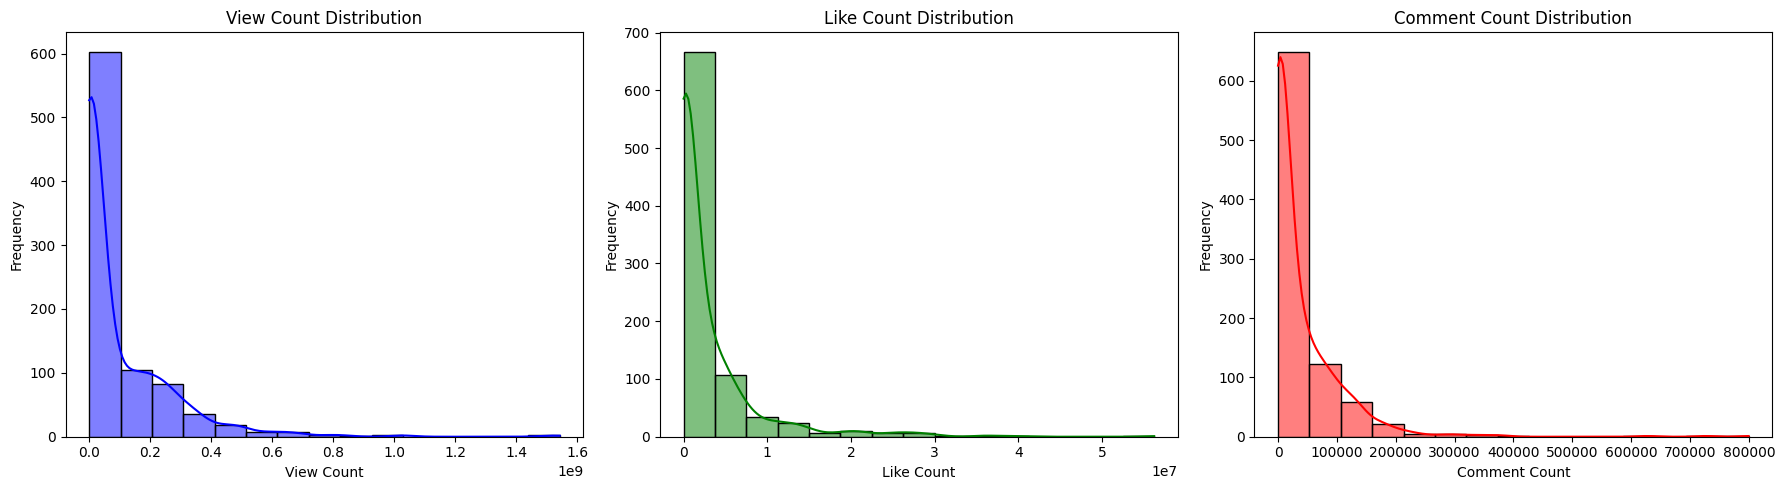

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# view count distribution
sns.histplot(video_stats_df['view_count'], bins=15, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(video_stats_df['like_count'], bins=15, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(video_stats_df['comment_count'], bins=15, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

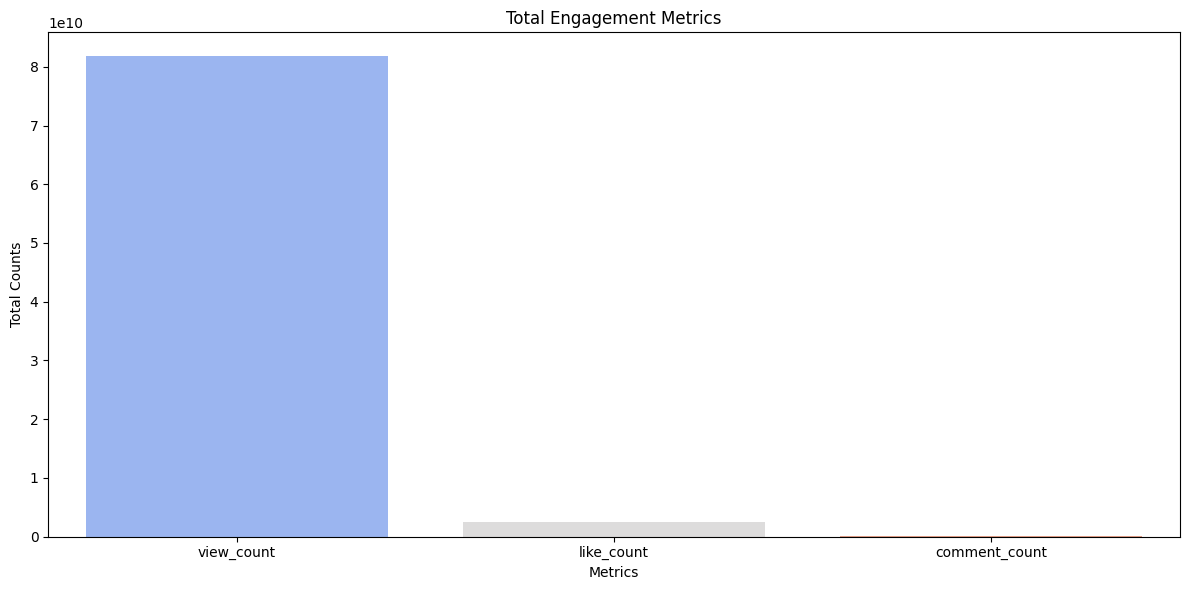

In [42]:
metrics = ['view_count', 'like_count', 'comment_count']

plt.figure(figsize=(12, 6))
sns.barplot(
    x=metrics,
    y=[video_stats_df['view_count'].sum(), video_stats_df['like_count'].sum(), video_stats_df['comment_count'].sum()],
    palette='coolwarm',
    hue=metrics
)
plt.title('Total Engagement Metrics')
plt.xlabel('Metrics')
plt.ylabel('Total Counts')
plt.tight_layout()
plt.show()

###### Correlation Heatmap: Shows relationships between engagement metrics.

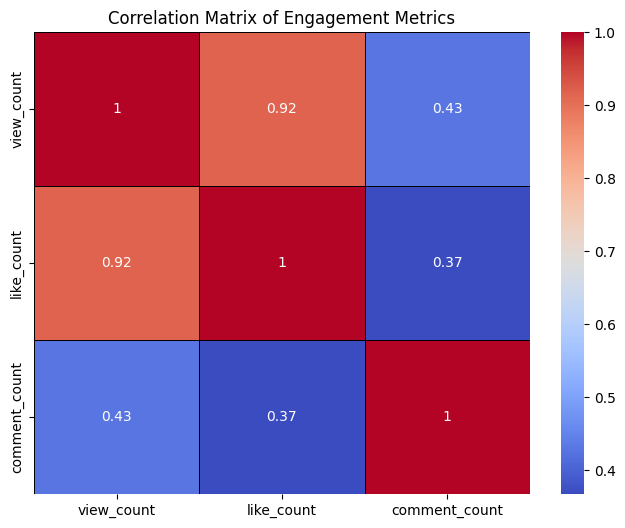

In [43]:
# correlation matrix
correlation_matrix = video_stats_df[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

###### Category Analysis: Bar charts for video counts and engagement by category.

In [44]:
# Add the counts on each bar
def annotate_bars(ax):
    for bar in ax.patches:
        count = int(bar.get_width())  # Bar width is the count
        y_pos = bar.get_y() + bar.get_height() / 2  # Center the annotation
        #ax.text(count/2 , y_pos, str(count), va='center', fontsize=10)  # Offset slightly to the midle
        ax.text(count + 1, y_pos, str(count), va='center', fontsize=10)  # Offset slightly to the right

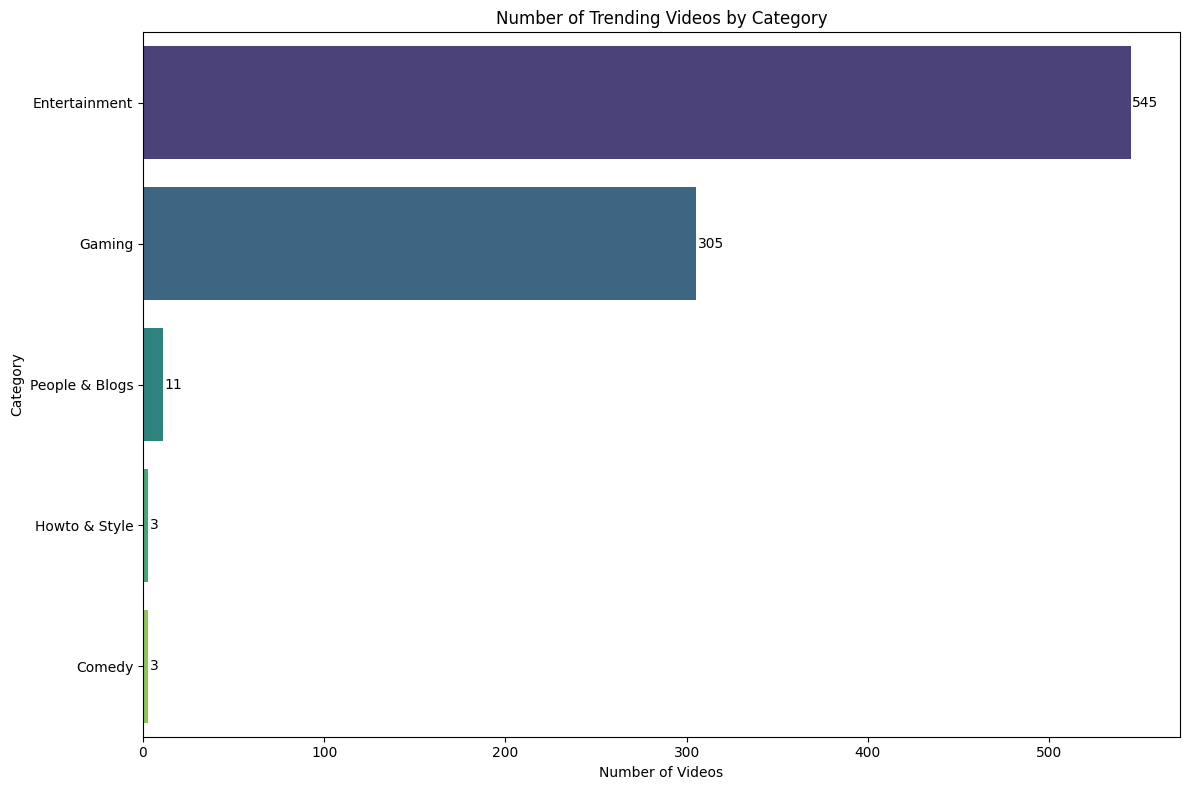

In [45]:
# Bar chart for category counts
plt.figure(figsize=(12, 8))
ax=sns.countplot(y=video_stats_df['category_name'], order=video_stats_df['category_name'].value_counts().index, hue=video_stats_df['category_name'], palette='viridis', legend=False )
# Add the counts on each bar
annotate_bars(ax)
# Chart formatting
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

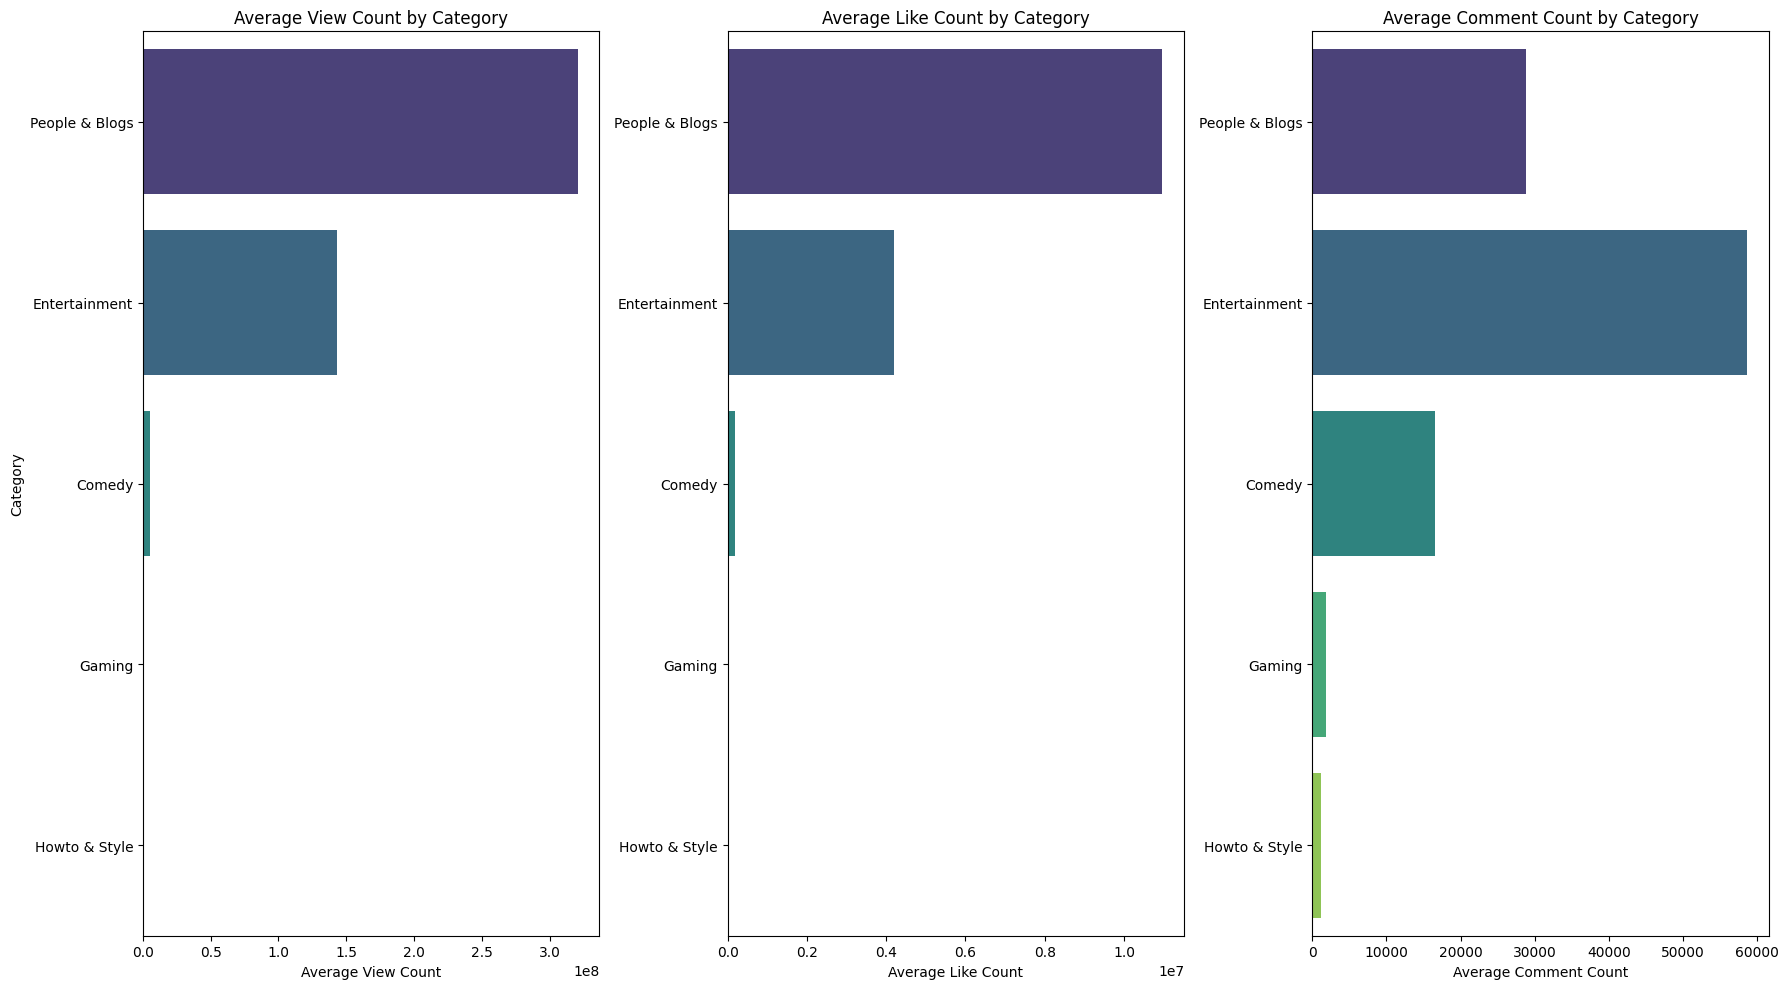

In [46]:
# average engagement metrics by category
category_engagement = video_stats_df.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis', hue=category_engagement.index, legend=False)
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

# like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis', hue=category_engagement.index, legend=False)
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis', hue=category_engagement.index, legend=False)
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

###### Video Length Impact: Scatter plots of duration vs. views and engagement by duration bins.

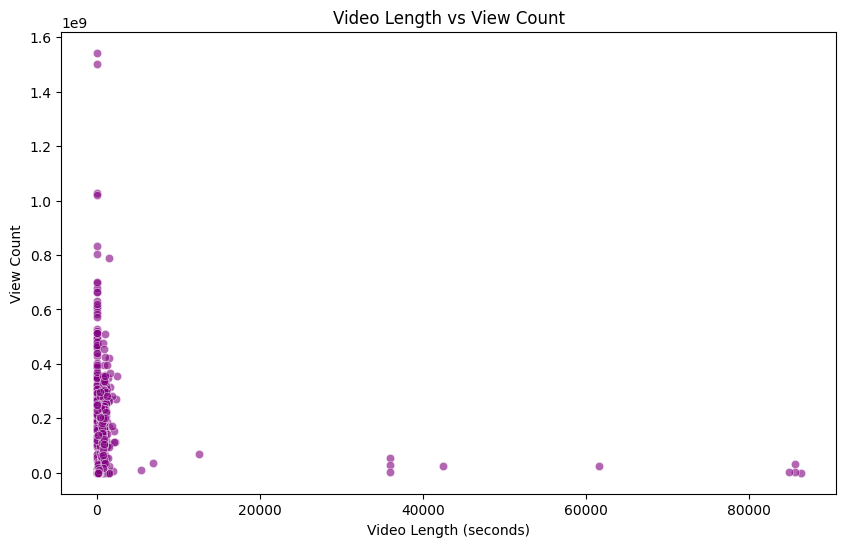

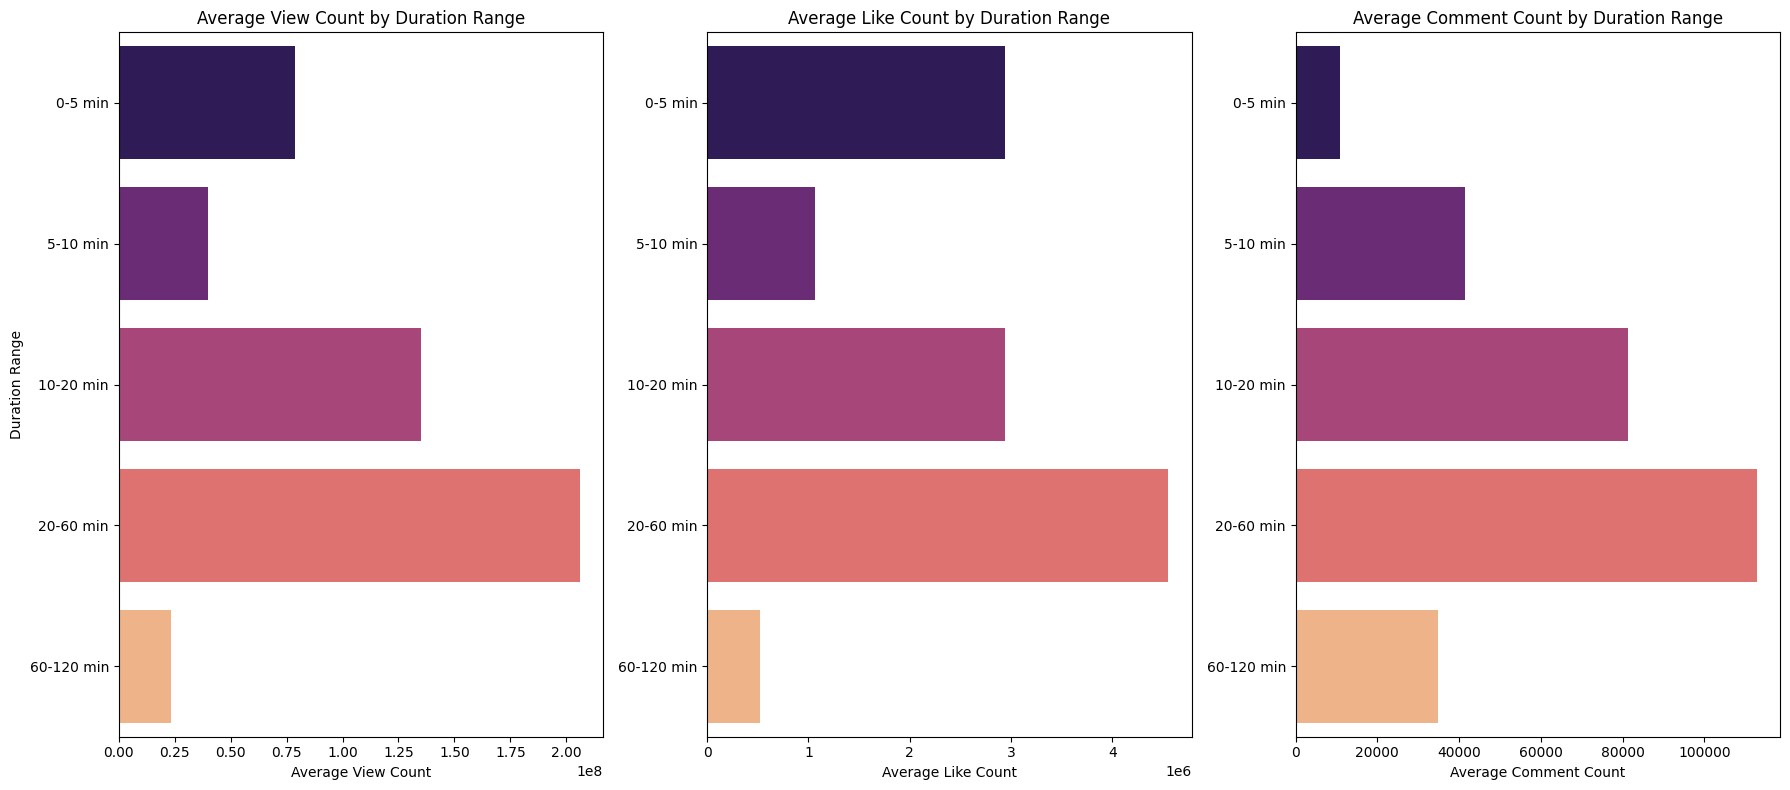

In [47]:
# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=video_stats_df, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = video_stats_df.groupby('duration_range', observed=False)[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma', hue=length_engagement.index, legend=False)
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma', hue=length_engagement.index, legend=False)
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma', hue=length_engagement.index, legend=False)
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

###### Tag Analysis: Tags vs. views.

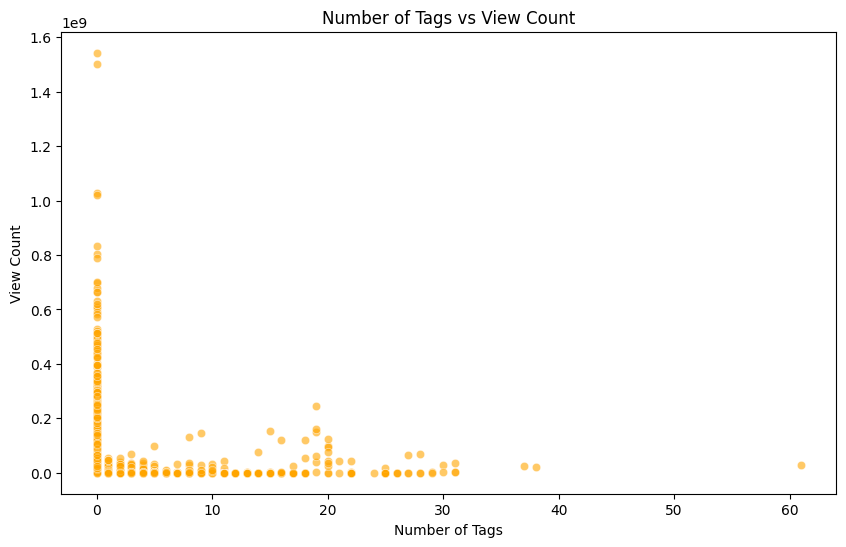

In [48]:

# scatter plot for number of tags vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=video_stats_df, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

###### Publish Time: Hourly distribution of video uploads.

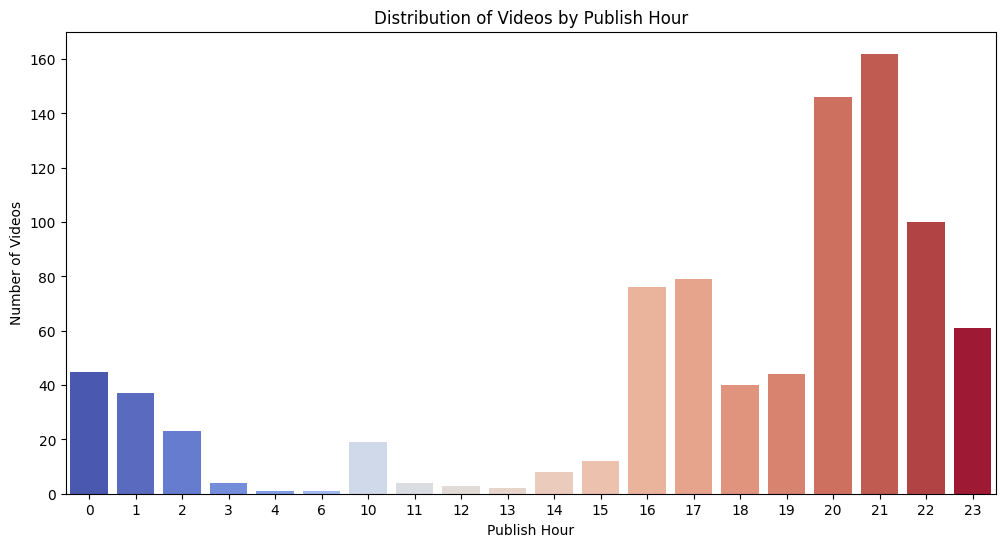

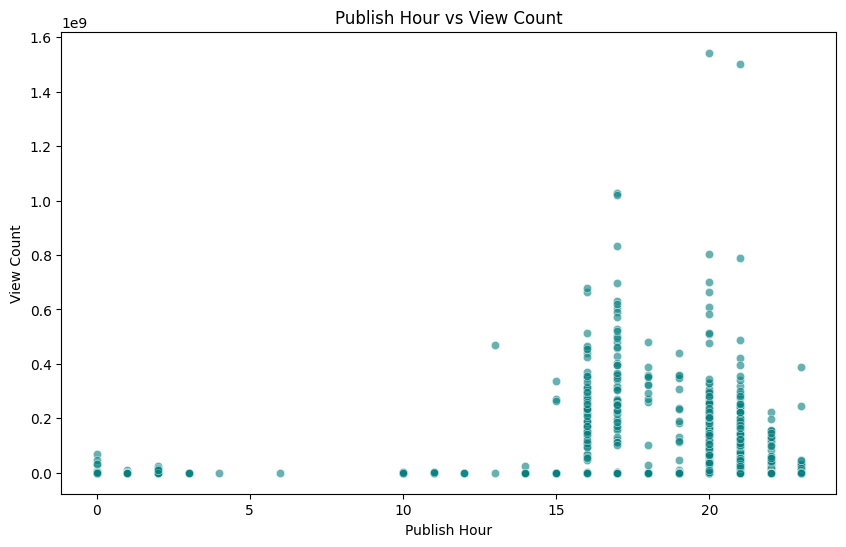

In [49]:
# bar chart for publish hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=video_stats_df, palette='coolwarm', hue='publish_hour', legend=False)
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=video_stats_df, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

###### Heatmaps for Publishing Times

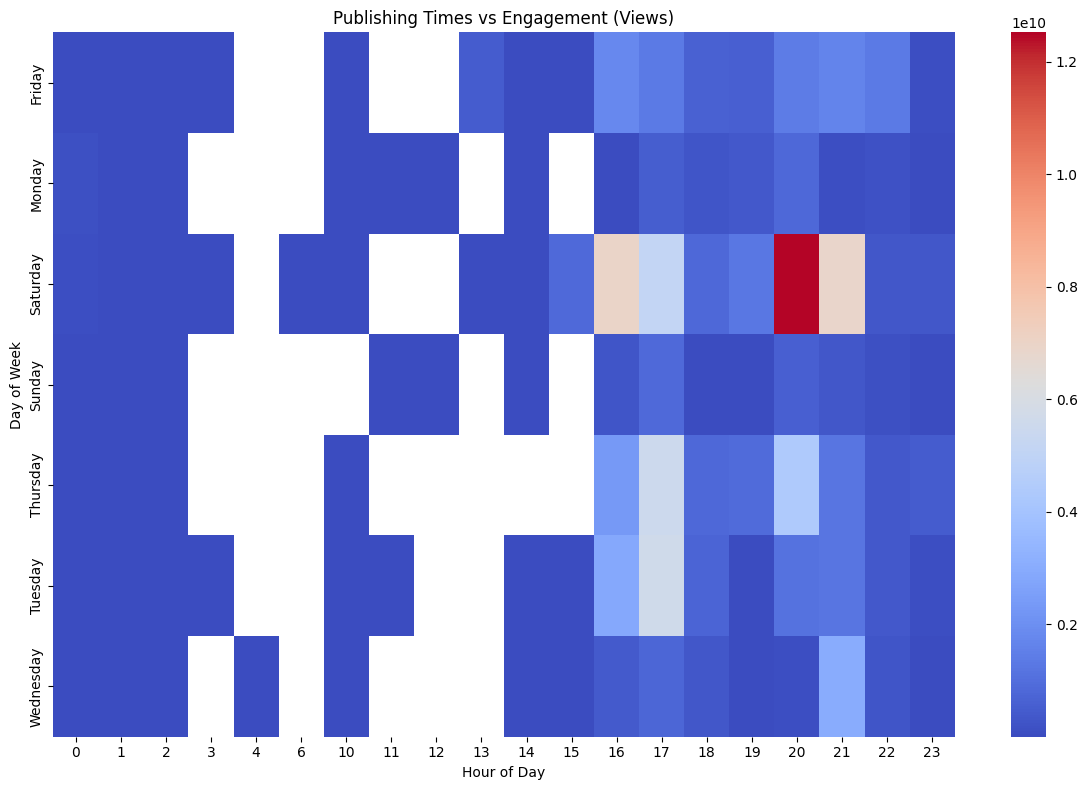

In [50]:
# Create a pivot table for heatmap
heatmap_data = video_stats_df.pivot_table(index='day_of_week', columns='publish_hour', values='view_count', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='.0f')
plt.title('Publishing Times vs Engagement (Views)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()